In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots;

In [3]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [4]:
# Parameters
grid_resolution        = 200
quadrature_order       = 5
ϵ                      = 3                # perturbation
selected_ev            = 1
t_initial              = minimum(Time)
t_end                  = t_initial+70     # parameter value corresponding to ϵ=0 (t_max is 90)
wind_scale             = 1e-5
wind_center            = 30;
solver_tolerance       = 1e-8
solver                 = OrdinaryDiffEq.BS5()
δ                      = 0.1;

In [5]:
lattitude_range = range(minimum(Lat),maximum(Lat),length=size(UT)[2]) # should be equal to Lat, but just to be safe
wind_u = repeat(collect(wind_scale.*(lattitude_range.-wind_center))',size(UT)[1],1,size(UT)[3])
wind_v = zero(VT); #no northward component of wind
wind = interpolateVF(Lon, Lat, Time, wind_u, wind_v);

In [6]:
# it would be much easier to write this with interp_rhs and p=UV .+ param.*wind, but that has the wrong type
interp_rhs_scaled = OrdinaryDiffEq.ODEFunction{false}((u,p,t) -> p[1](u[1],u[2],t) .+ p[3].*p[2](u[1],u[2],t))
function T(x,param)
    flow(interp_rhs_scaled, x, [t_initial, t_end]; 
        p=(UV, wind, param), tolerance=solver_tolerance, solver=solver)[end]
end

T (generic function with 1 method)

In [7]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
lon_resolution = grid_resolution
lat_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))
ctx, _ = regularTriangularGrid((lon_resolution, lat_resolution), 
        LL, UR, quadrature_order = quadrature_order);
bdata = getHomDBCS(ctx, "all");

In [8]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [9]:
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata);

174.901311 seconds (95.48 M allocations: 5.413 GiB, 0.74% gc time)


In [10]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀[:,selected_ev])
λ₀ = real.(λ₀[selected_ev])
u₀ = u₀ ./ sqrt(u₀'*M*u₀)        # L2 normalization
#if u₀[Int(floor(0.75*lat_resolution*lon_resolution+0.75*lon_resolution))]<0
#   u₀ = -u₀
#end
λ₀

  3.352690 seconds (9.28 M allocations: 596.319 MiB, 3.93% gc time)


-10.453314774414967

In [11]:
DT₀minus(x) = linearized_flow_autodiff(y -> T(y,-δ) , x)
A₀minus(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀minus(x))))
@time Kminus = assembleStiffnessMatrix(ctx, A₀minus, bdata=bdata);
@time λ₀minus, u₀minus = eigs(Kminus, M, which=:SM)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀minus = real.(u₀minus[:,selected_ev])
λ₀minus = real.(λ₀minus[selected_ev])
u₀minus = u₀minus ./ sqrt(u₀minus'*M*u₀minus);        # L2 normalization
#if u₀minus[Int(floor(0.75*lat_resolution*lon_resolution+0.75*lon_resolution))]<0
#    u₀minus = -u₀minus
#end

165.127279 seconds (58.47 M allocations: 3.265 GiB, 0.32% gc time)
  0.392151 seconds (1.53 k allocations: 104.811 MiB, 2.63% gc time)


In [12]:
DT₀plus(x) = linearized_flow_autodiff(y -> T(y,δ) , x)
A₀plus(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀plus(x))))
@time Kplus = assembleStiffnessMatrix(ctx, A₀plus, bdata=bdata);
@time λ₀plus, u₀plus = eigs(Kplus, M, which=:SM)
@assert all(imag.(u₀plus) .== 0)
@assert all(imag.(λ₀plus) .== 0)
u₀plus = real.(u₀[:,selected_ev])
λ₀plus = real.(λ₀[selected_ev])
u₀plus = u₀plus ./ sqrt(u₀plus'*M*u₀plus);        # L2 normalization
#if u₀plus[Int(floor(0.75*lat_resolution*lon_resolution+0.75*lon_resolution))]<0
#    u₀plus = -u₀plus
#end

165.077541 seconds (57.94 M allocations: 3.250 GiB, 0.32% gc time)
  0.372436 seconds (1.35 k allocations: 96.771 MiB, 2.84% gc time)


In [13]:
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot,bdata=bdata)
@time u_dot0, λ_dot0 = getLinearResponse(u₀,λ₀,M,K,L);

1760.182959 seconds (12.29 G allocations: 1.462 TiB, 9.59% gc time)
  1.760235 seconds (4.16 M allocations: 428.110 MiB, 3.70% gc time)


In [14]:
Adotminus = x -> linear_response_tensor(T, x, -δ)
@time Lminus = assembleStiffnessMatrix(ctx, Adotminus,bdata=bdata)
@time u_dotminus, λ_dotminus = getLinearResponse(u₀minus,λ₀minus,M,Kminus,Lminus);

1788.618086 seconds (12.29 G allocations: 1.462 TiB, 9.52% gc time)
  0.207228 seconds (289 allocations: 88.105 MiB, 4.33% gc time)


In [15]:
Adotplus = x -> linear_response_tensor(T, x, +δ)
@time Lplus = assembleStiffnessMatrix(ctx, Adotplus,bdata=bdata)
@time u_dotplus, λ_dotplus = getLinearResponse(u₀plus,λ₀plus,M,Kplus,Lplus);

1791.932636 seconds (12.26 G allocations: 1.461 TiB, 9.53% gc time)
  0.188804 seconds (289 allocations: 86.976 MiB)


In [16]:
# calculate the exact uϵ
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata)
λϵ, uϵ = eigs(Kϵ, M, which=:SM)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ[:,selected_ev])
λϵ = real.(λϵ[selected_ev])
uϵ = uϵ ./ sqrt(uϵ'*M*uϵ)
#if uϵ[Int(floor(0.75*lat_resolution*lon_resolution+0.75*lon_resolution))]<0
#    uϵ = -uϵ
#end
λϵ

-10.247831995874327

In [17]:
λ₀ + ϵ*λ_dot0 

22.195042056903443

In [18]:
λ_dot = 0.25λ_dotminus + 0.5λ_dot0 + 0.25λ_dotplus

-40.55702907593714

In [19]:
λ₀ + ϵ*λ_dot 

-132.1244020022264

In [44]:
u_dot = - 0.25u_dotminus + 0.5u_dot0 + 0.25u_dotplus;

In [21]:
color =    :balance
xticks =   -4:2:6
yticks =   -34:2:-28
colorbar = :left
cmin =     -1
cmax =     1
cmin_lr =  -1
cmax_lr =  1;
#unfortunately there is no option for colorbar ticks

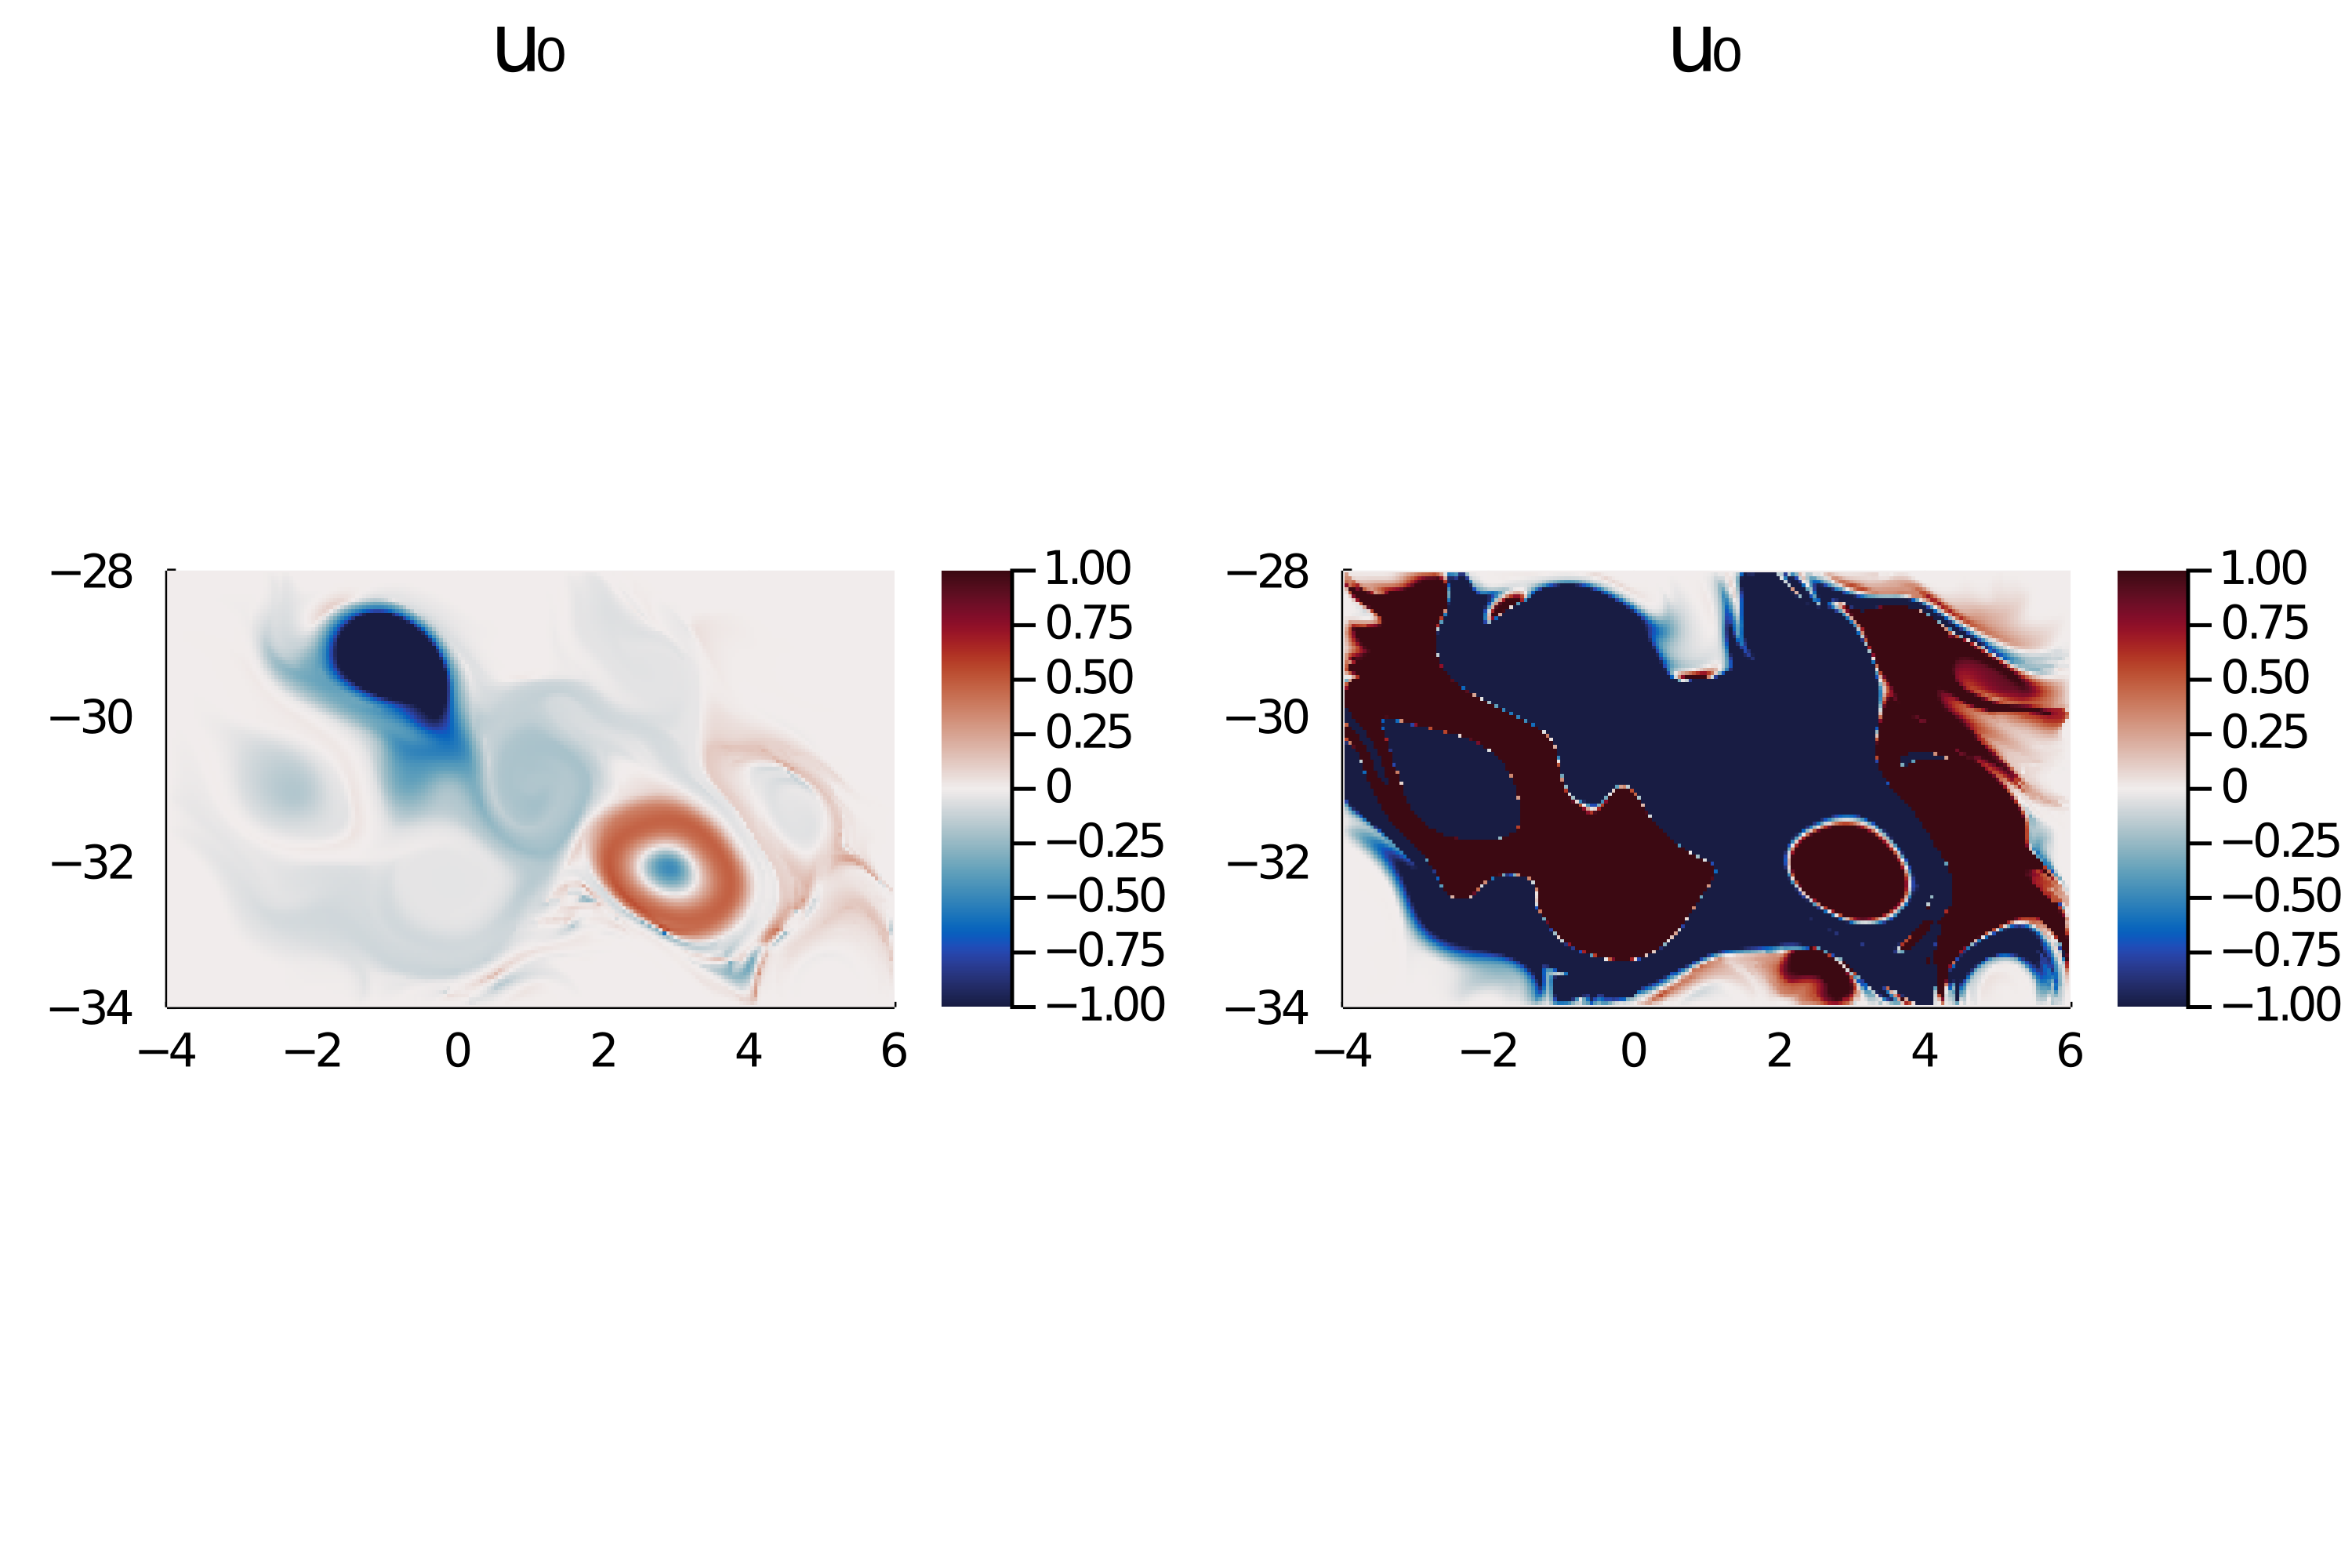

In [45]:
unaveraged      = plot_u(ctx, u_dot0,           lon_resolution, lat_resolution, title="u₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
averaged        = plot_u(ctx, u_dot,           lon_resolution, lat_resolution, title="u₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(unaveraged,averaged, fmt=:png, dpi=500)

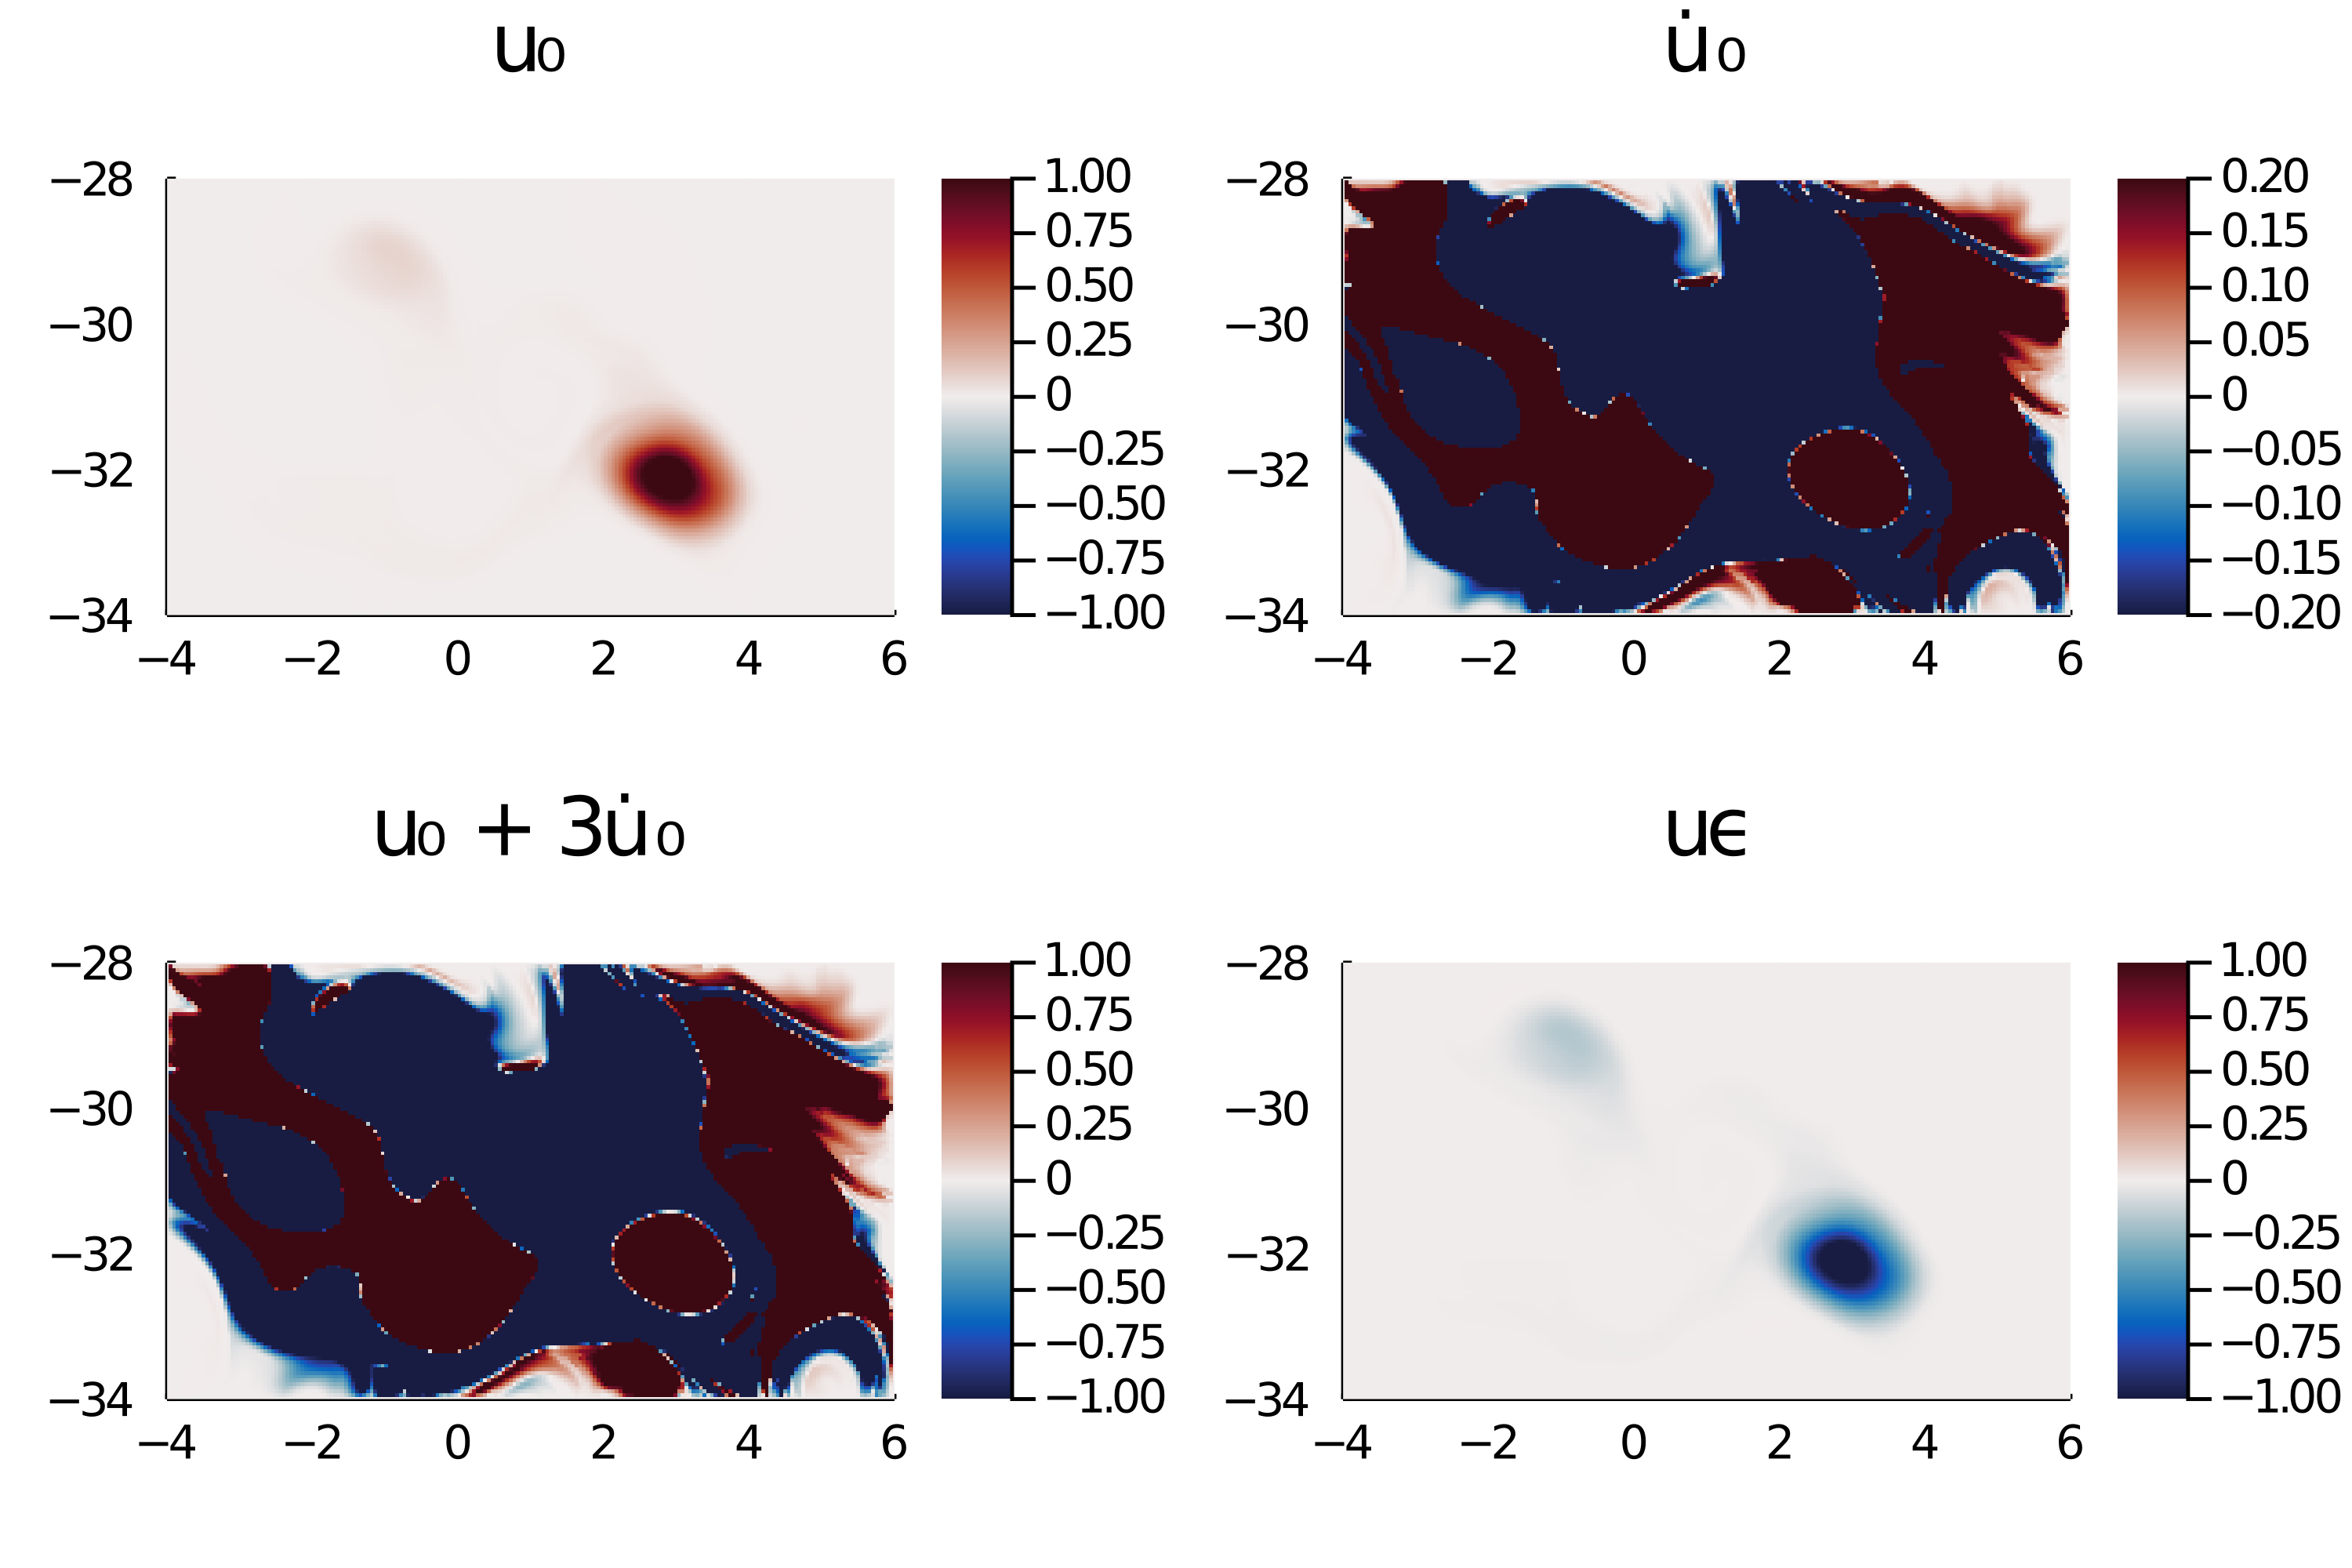

In [23]:
color =    :balance
xticks =   -4:2:6
yticks =   -34:2:-28
colorbar = :left
cmin =     -1
cmax =     1
cmin_lr =  -0.2
cmax_lr =  0.2
#unfortunately there is no option for colorbar ticks


original      = plot_u(ctx, u₀,           lon_resolution, lat_resolution, title="u₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
derivative    = plot_u(ctx, u_dot,       lon_resolution, lat_resolution, title="u̇ ₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
extrapolated  = plot_u(ctx, u₀ + ϵ*u_dot, lon_resolution, lat_resolution, title="u₀ + $(ϵ)u̇ ₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
exact         = plot_u(ctx, uϵ,          lon_resolution, lat_resolution, title="uϵ", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(original,derivative,extrapolated,exact, fmt=:png, dpi=500)

In [24]:
# calculate the exact uminusϵ
DTminusϵ(x) = linearized_flow_autodiff(y -> T(y,-ϵ) , x)
Aminusϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTminusϵ(x))))
Kminusϵ = assembleStiffnessMatrix(ctx, Aminusϵ, bdata=bdata)
λminusϵ, uminusϵ = eigs(Kminusϵ, M, which=:SM)
@assert all(imag.(uminusϵ) .== 0)
@assert all(imag.(λminusϵ) .== 0)
uminusϵ = real.(uminusϵ[:,selected_ev])
λminusϵ = real.(λminusϵ[selected_ev])
uminusϵ = uminusϵ ./ sqrt(uminusϵ'*M*uminusϵ)
#if uminusϵ[Int(floor(0.75*lat_resolution*lon_resolution+0.75*lon_resolution))]<0
#    uminusϵ = -uminusϵ
#end
λminusϵ

-10.575613087062052

In [25]:
λ₀ - ϵ*λ_dot 

111.21777245339645

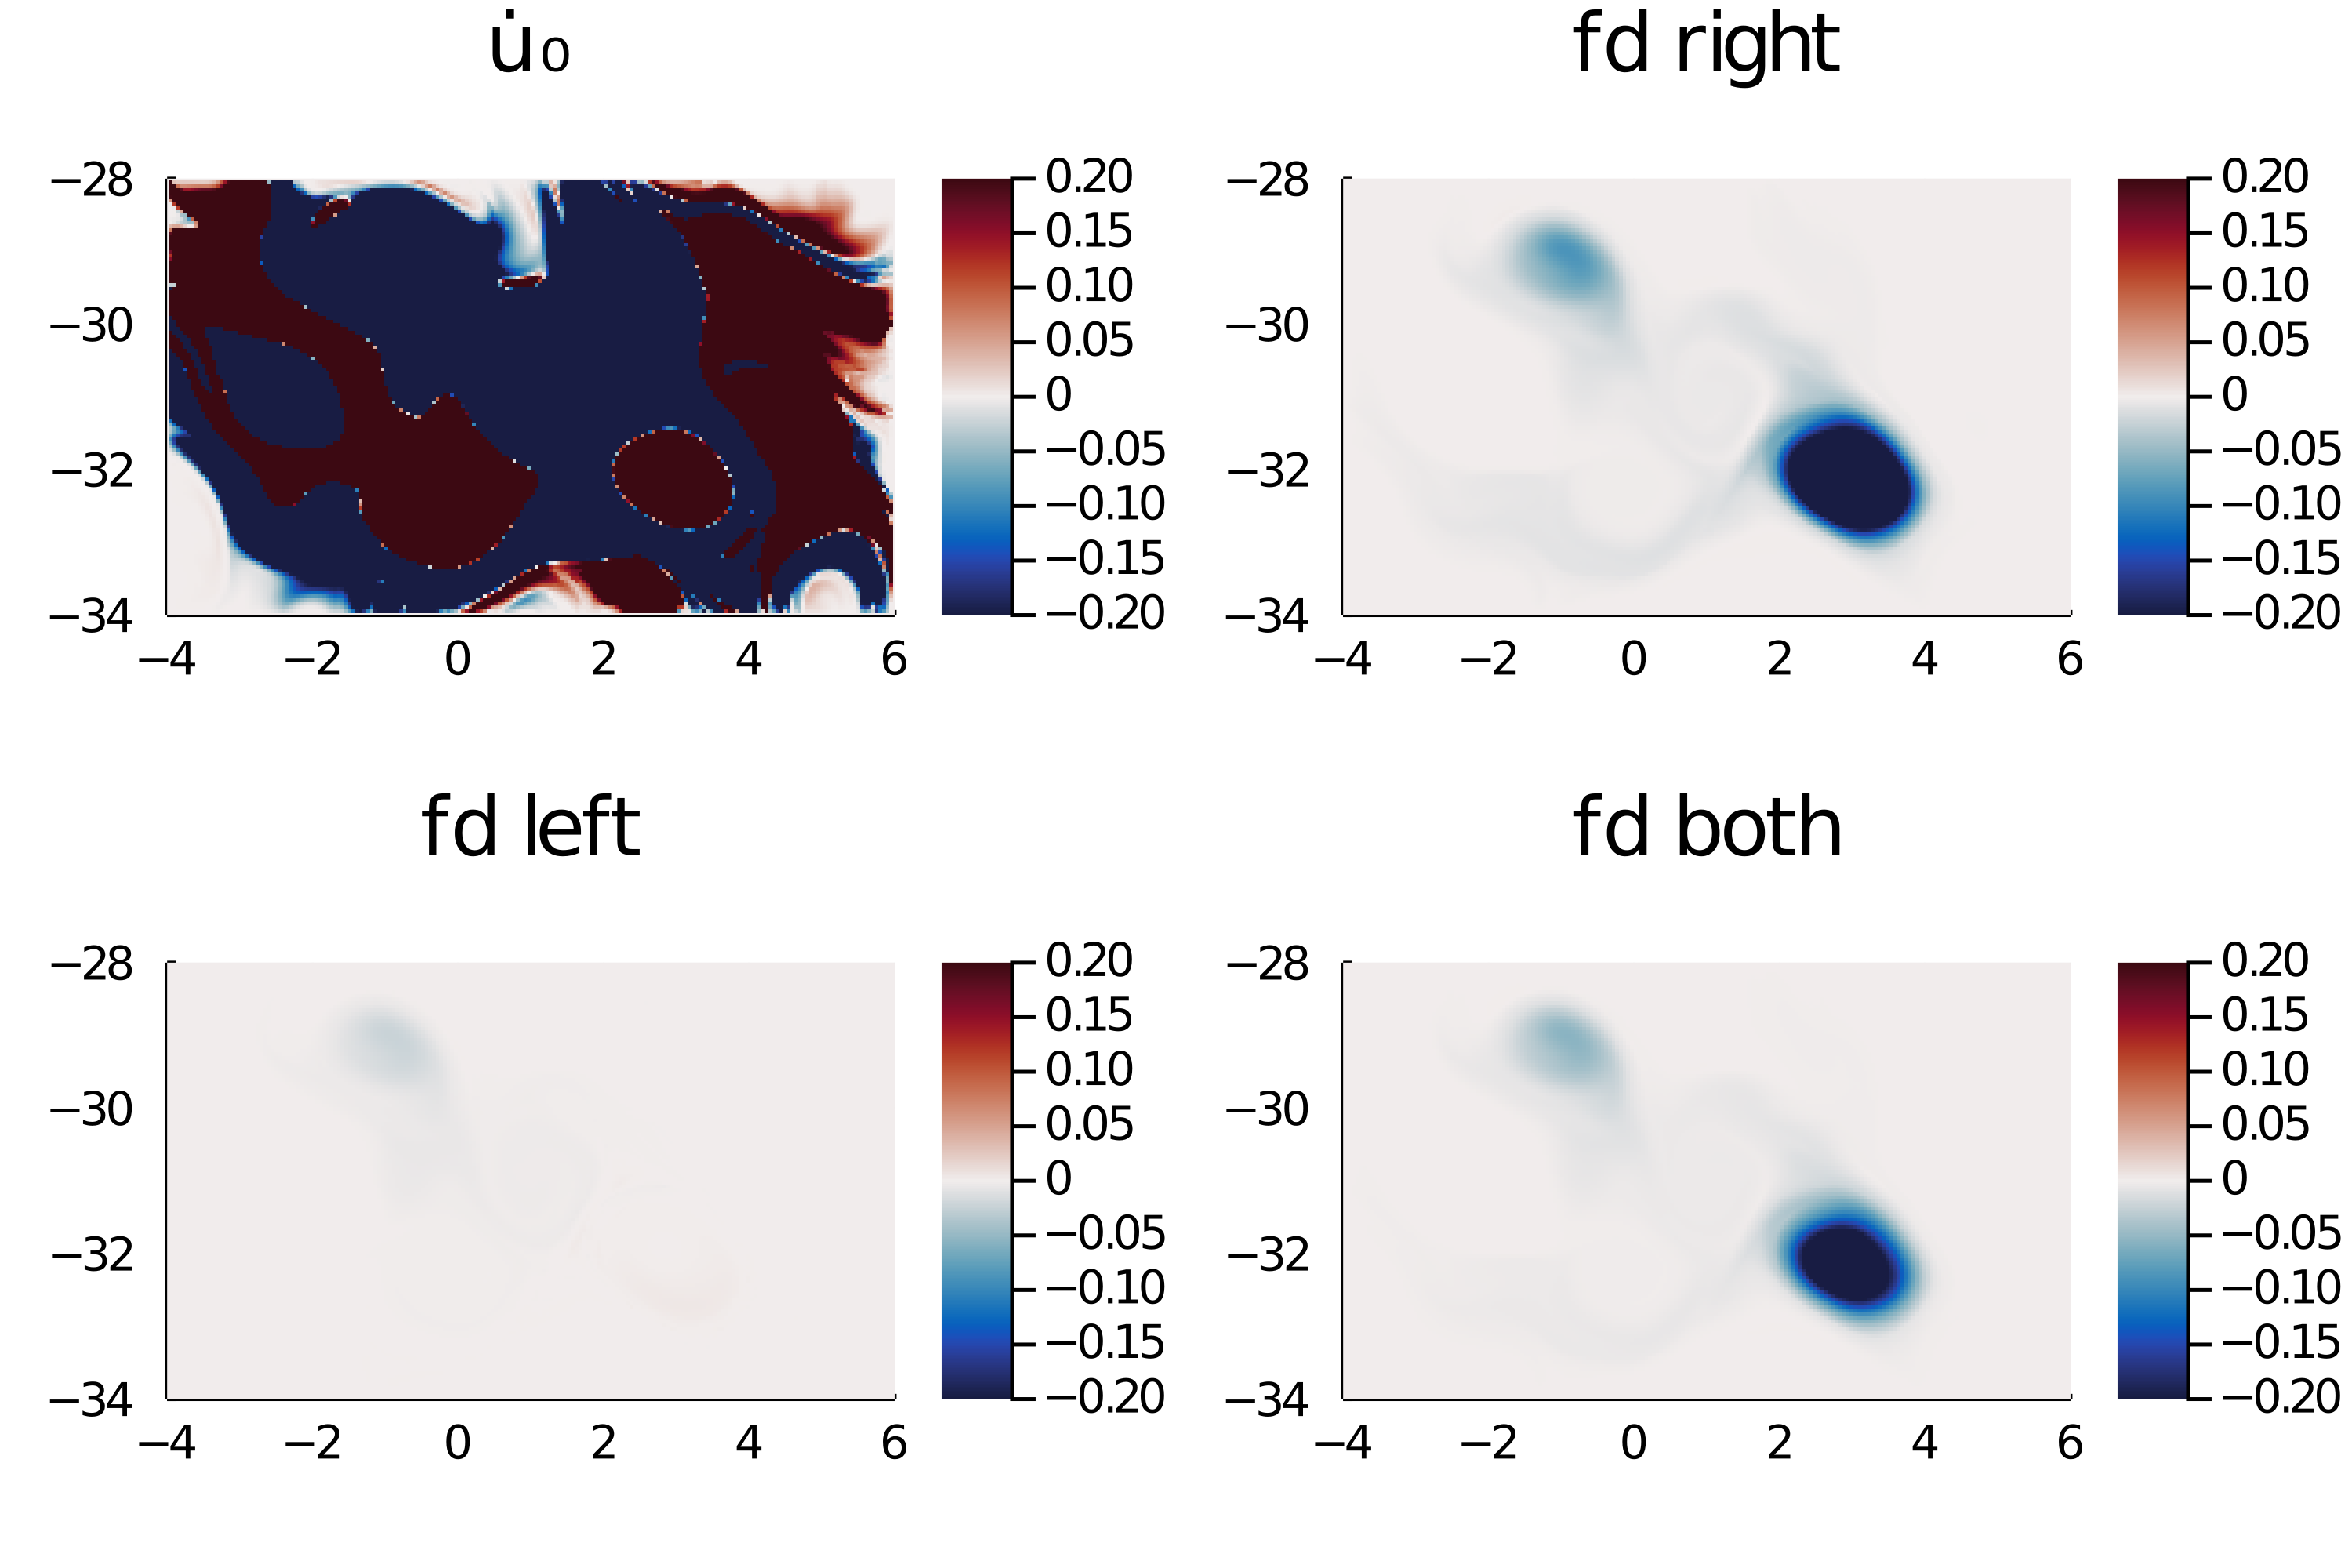

In [26]:
finite_diff_right = plot_u(ctx, (uϵ - u₀)/ϵ,          lon_resolution, lat_resolution, title="fd right", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
finite_diff_left = plot_u(ctx, (u₀ - uminusϵ)/ϵ,          lon_resolution, lat_resolution, title="fd left", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
finite_diff_both = plot_u(ctx, (uϵ - uminusϵ)/ 2ϵ,          lon_resolution, lat_resolution, title="fd both", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
Plots.plot(derivative,finite_diff_right,finite_diff_left,finite_diff_both, fmt=:png, dpi=500)

In [27]:
using Contour

In [28]:
function dynamic_cheeger_value_levelset(levelset)
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,x->T(x,0),tolerance=1e-10)
end
function dynamic_cheeger_value_levelset_nonnegative(levelset)
    if level(levelset) < 0
        return Inf
    end
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: $(level(levelset))"
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,x->T(x,0),tolerance=1e-10)
end

best_levelset, best_value = get_minimal_levelset(
    ctx,u₀,dynamic_cheeger_value_levelset,n_candidates=1000,bdata=bdata)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.00033938663175332186)
└ @ Main In[28]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0009651582926898763)
└ @ Main In[28]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.002269703217133074)
└ @ Main In[28]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.003574248141576272)
└ @ Main In[28]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0048787930660194705)
└ @ Main In[28]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.006183337990462669)
└ @ Main In[28]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.007487882914905866)
└ @ Main In[28]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.008792427839349064)
└ @ Main In[28]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0100969

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11576511164369131)
└ @ Main In[28]:4


Dynamic Cheeger value:	2.4803441307803467
Levelset:		0.15620600430143047


2.4803441307803467	5.625577196787871	6.463473214764788	2.4369703908282467


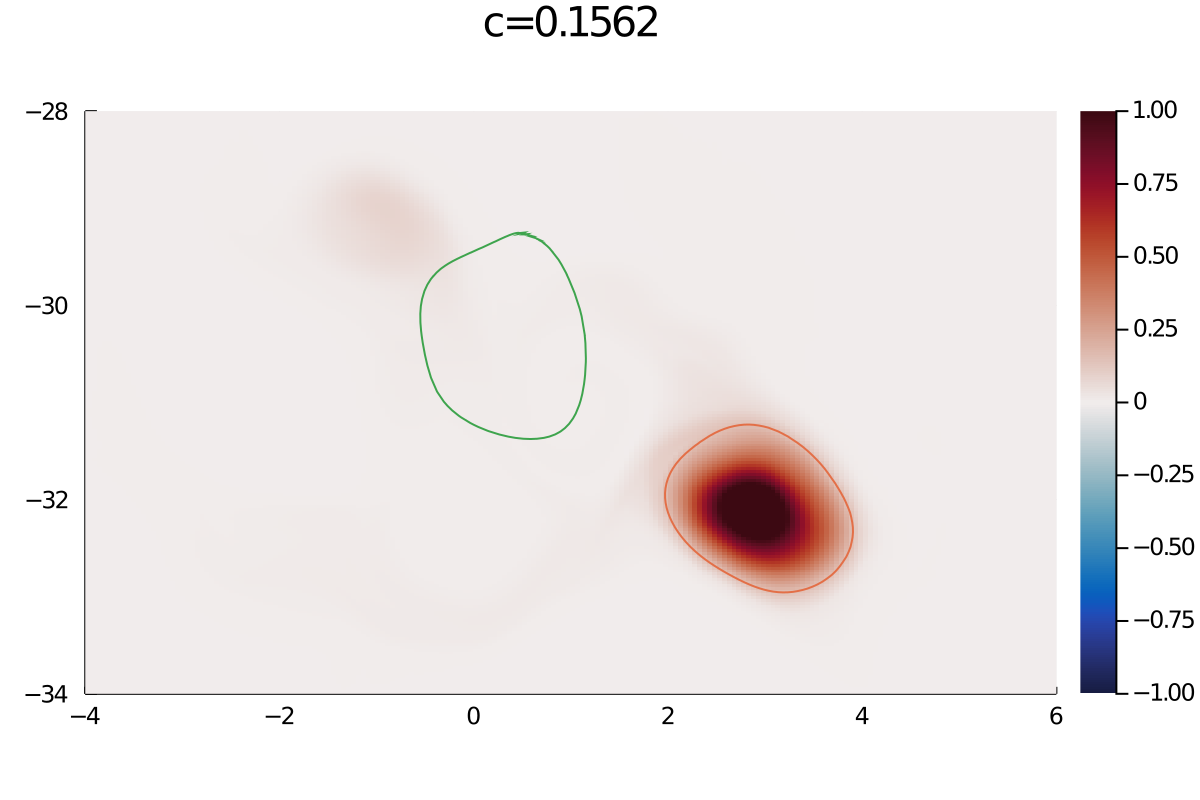

In [29]:
c_best = level(best_levelset)
plot_best = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c_best,digits=4))",bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curve = lines(get_levelset(ctx, u₀, c_best, bdata=bdata))[1]
curve = Main.CoherentStructures.closeCurve(ctx,curve)
curve_moved = Main.CoherentStructures.apply2curve(x->T(x,0),curve)

cheeger_value = dynamic_cheeger_value(ctx, curve, x->T(x,0))
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curve))\t",
    "$(Main.CoherentStructures.getLength(curve_moved))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curve))\n")

Plots.plot!(coordinates(curve))
Plots.plot!(coordinates(curve_moved))


Plots.plot!(fmt=:png,dpi=200)

In [30]:
using PyCall
using PyPlot
@pyimport matplotlib.pyplot as plt

ErrorException: [91m@pyimport: plt already defined[39m

In [31]:
function plot_vectorfield(xs,ys,dx,dy,ax;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    dx, dy = dx[1:step:end,1:step:end], dy[1:step:end,1:step:end]
    ax.quiver(xs,ys,dx',dy',scale=scale,color="blue")
end

plot_vectorfield (generic function with 1 method)

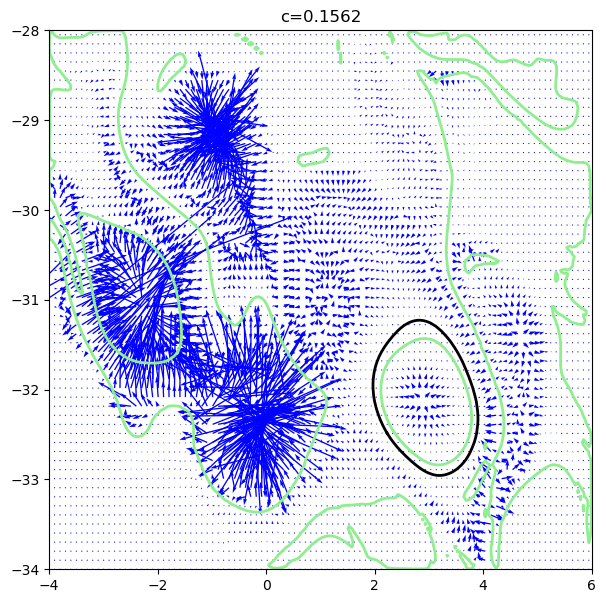

In [33]:
plt.figure(figsize=(7,7), dpi=100)
ax = plt.axes()
ax.set(xlim=(-4,6), ylim=(-34,-28))
plot_vectorfield(get_levelset_evolution(ctx,u₀,u_dot,bdata=bdata)...,ax,scale=1000,step=2)
curves           = lines(get_levelset(ctx, u₀, c_best,bdata=bdata))
curves_epsilon   = lines(get_levelset(ctx, uϵ, c_best,bdata=bdata))
curves_predicted = lines(get_levelset(ctx, u₀ + ϵ*u_dot, c_best,bdata=bdata))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");